In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

## Pre-Task: Describe the goals of your study

Problem Statement:
In this project we are attempting to predict if a person would survive the Titanic distaster. 

We are given categorical and numeric data on 891 passengers aboard the ship. The process of solving this problem involves the general data science workflow:

1. Identify the problem: calculate the probability that someone survives the titanic distaster
2. Acquire the data: connect to PostgresSQL database and download the training set to csv
3. Parse the data: see how many passengers there are, check the .head()
4. Mine the data: check for missing values, fill or remove them, use train_test_split to divide it
5. Refine the data: check data dtypes, convert categorical variables to numeric dummies
6. Build a model: this is a classification problem, so I will use logistic regression and k nearest neighbors as my models, tune them with grid search and check accuracy scores.

These steps lead us to an actual probability output of whether we think a person would live or die. When tasked broadly with assessing a firms risk management ability, this modeling process could contribute to scoring a firms risk competence. 

After our analysis, we see that our model predicted a 39% survival rate for passengers aboard the ship compared with the actual survival rate of 32% (actual is an estimate as there is no exact survivor count).  Using logistic regression with cross validation gave us a 79% acccurate model, while using knn with 3 neighbors also yielded a 79% accurate model. These accuracies can change by a few percentage points based on how our train_test_split splits our data.


## Part 1: Aquire the Data

In [2]:
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents

#### 2. Query the database and aggregate the data

In [3]:
#\COPY public.train TO '~/Desktop/train.csv' DELIMITER ',' CSV HEADER;
#This line in terminal will copy the training table to csv retaining the headers of each column!

#### 5. What are the risks and assumptions of our data? 

We made some assumptions along the way due to the nature of the data set. We had to fill missing values for the age of 177 passengers in addition to dropping 2 passengers with missing embarking data. Again we also assume a normal distribution which could effect our findings. 


## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [2]:
#Once downloaded, load csv into notebook for exploratory analysis 
data = pd.read_csv('~/DSI/Week-6/project-05/train.csv')
#check out the first 5 rows to get a feel for the data
print "The passenger total is:", len(data)
data.head()

The passenger total is: 891


,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#check for nulls, nans, missing values
print "Below we see 177 NaNs for Age, 687 for Cabin, and 2 for embarked"
data.isnull().sum()

Below we see 177 NaNs for Age, 687 for Cabin, and 2 for embarked


index            0
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#Because there are so many missing values for Cabin, we will drop that column entirely. We will also drop the 2
#who have missing embarked data. 
data.drop('Cabin', axis=1, inplace=True)

In [5]:
#set the data set equal to the data set minus the rows where Embarked are null
data = data[pd.notnull(data['Embarked'])]

In [6]:
#Now we must deal with the missing Age values. I decided to fill the 177 missing values with the average age of all
#all passengers. This will impact the model differently than dropping them or filling with 0's. 
data = data.fillna(data.mean())

In [7]:
#We can also drop the "name" column as it's redundant with passengerID and drop "fare" as it describes essentially the
#Pclass of each passenger. We also drop Ticket as this won't help us with regression. These drops will speed up our 
#analysis later
data.drop('Fare', axis=1, inplace=True)
data.drop('Name', axis=1, inplace=True)
data.drop('Ticket', axis=1, inplace=True)

#### 2. Visualize the Data

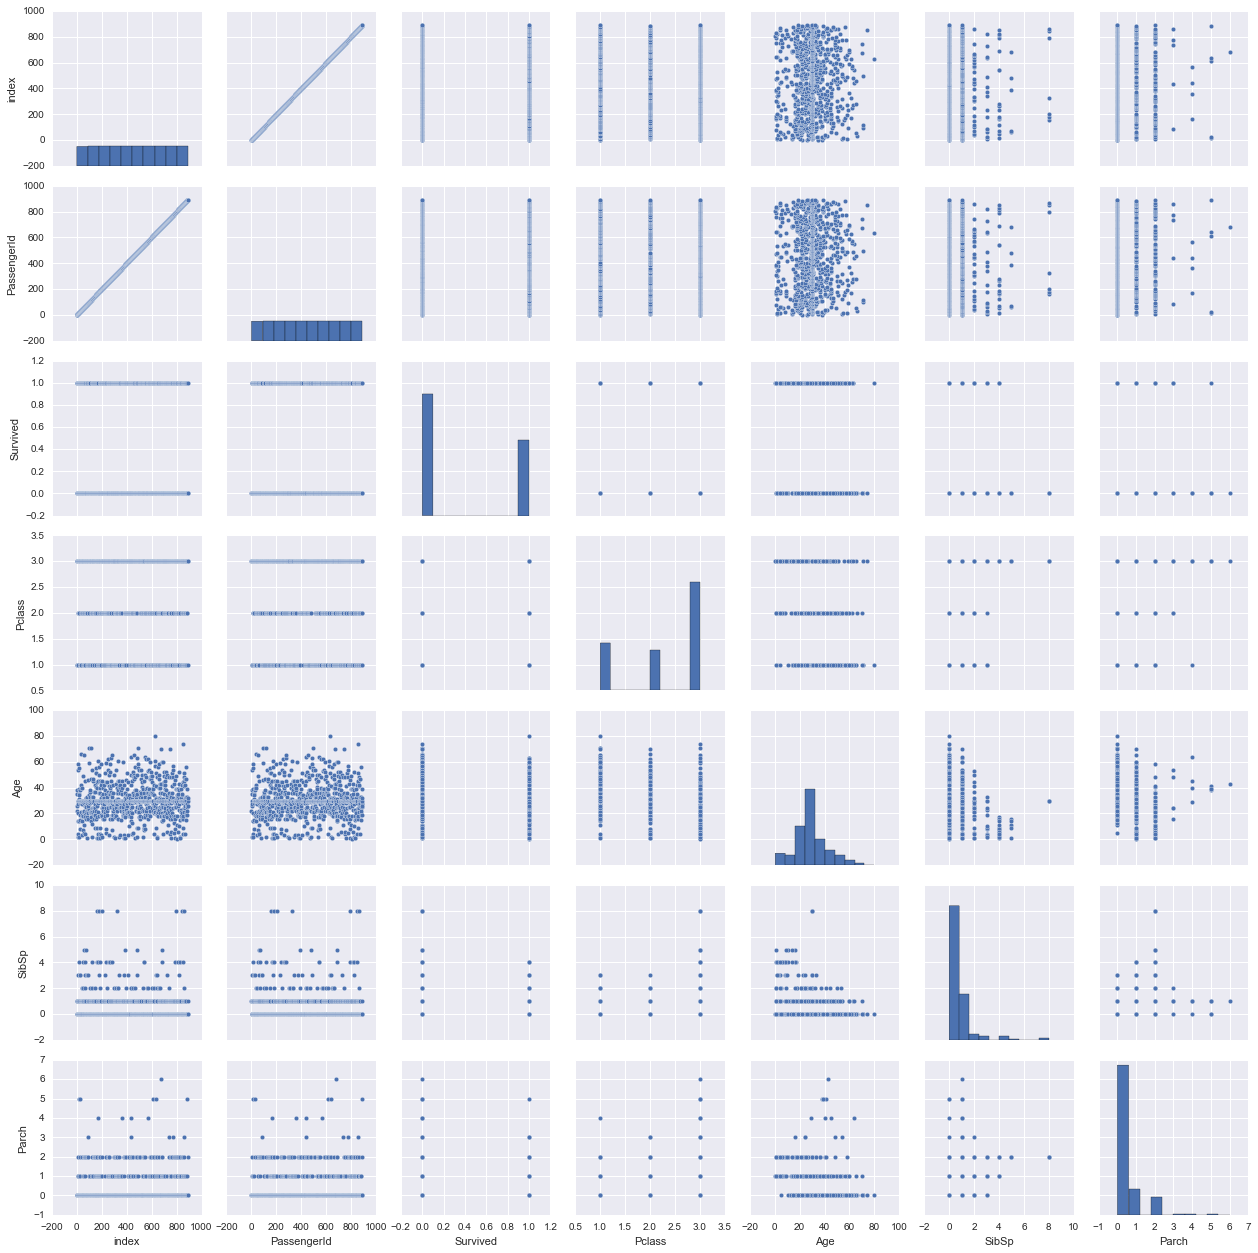

In [8]:
#run a pairplot to see any large picture correlations
sns.pairplot(data)

In [9]:
data.head()

,index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,1,0,3,male,22.0,1,0,S
1,1,2,1,1,female,38.0,1,0,C
2,2,3,1,3,female,26.0,0,0,S
3,3,4,1,1,female,35.0,1,0,S
4,4,5,0,3,male,35.0,0,0,S


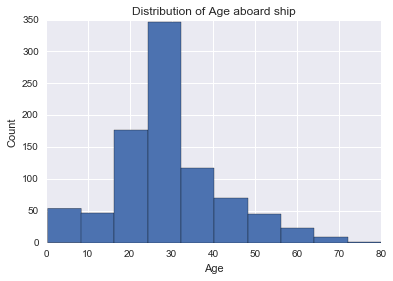

In [10]:
#Plot the age distribution. You will see a spike in age 30 because we replaced 177 NaN's with 29
plt.hist(data.Age)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age aboard ship")

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [11]:
#map dummies for sex
data['Sex'] = data['Sex'].map({'male':0, 'female':1})

In [12]:
#map dummies for embarked
data['Embarked'] = data['Embarked'].map({'C':0, 'Q':1,'S':2})

In [13]:
data.dtypes

index            int64
PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Embarked         int64
dtype: object

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [39]:
#set the feature columns to be everything except index, survived, and passengerid
featurecols = [c for c in data.columns if c not in ['index','Survived','PassengerId']]
featurecols

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [15]:
#Set X to be our feature columns that have already been made numeric if needed
X = data[featurecols]
#Set y to our target
y = data['Survived']

#### 3. Conduct the logistic regression

In [16]:
lr = LogisticRegression()
cvscore = cross_val_score(lr, X , y)
print "Accuracy score: ", cvscore.mean()

Accuracy score:  0.793024084691


#### 4. Examine the coefficients to see our correlations

In [41]:
print "The log coefficients are:", lr.coef_

The log coefficients are: [[-0.9610496   2.52874964 -0.02701172 -0.19284532 -0.12208054 -0.18494074]]


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)
model = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

print "Accuracy score: ", accuracy_score(predictions, y_test)

Accuracy score:  0.797752808989


#### 7. Predict the class labels for the *Test* set

In [19]:
lived = 0
died = 0
for i in predictions:
    if i == 1:
        lived = lived +1
    elif i == 0:
        died = died +1

liverate = lived/len(predictions)        

print "The model predicts that from our testing set, the number of dead is:", died
print "The model predicts that from our testing set, the number that survived is:", lived
print "The survival rate from our testing set is therefore:", 68.0/len(predictions)

The model predicts that from our testing set, the number of dead is: 110
The model predicts that from our testing set, the number that survived is: 68
The survival rate from our testing set is therefore: 0.38202247191


In [20]:
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

#### 8. Predict the class probabilities for the *Test* set

In [21]:
#here we see the probability that a given individual will live or die
lr.predict_proba(X_test)

array([[ 0.84888047,  0.15111953],
       [ 0.41381354,  0.58618646],
       [ 0.46243137,  0.53756863],
       [ 0.93643319,  0.06356681],
       [ 0.75988027,  0.24011973],
       [ 0.6548313 ,  0.3451687 ],
       [ 0.38787122,  0.61212878],
       [ 0.88782525,  0.11217475],
       [ 0.89292541,  0.10707459],
       [ 0.72803084,  0.27196916],
       [ 0.87304252,  0.12695748],
       [ 0.66471177,  0.33528823],
       [ 0.87660546,  0.12339454],
       [ 0.63107418,  0.36892582],
       [ 0.65006455,  0.34993545],
       [ 0.54759882,  0.45240118],
       [ 0.94701018,  0.05298982],
       [ 0.26058734,  0.73941266],
       [ 0.05416362,  0.94583638],
       [ 0.94297554,  0.05702446],
       [ 0.8675692 ,  0.1324308 ],
       [ 0.1900478 ,  0.8099522 ],
       [ 0.07101418,  0.92898582],
       [ 0.11648348,  0.88351652],
       [ 0.28007573,  0.71992427],
       [ 0.53658894,  0.46341106],
       [ 0.5142345 ,  0.4857655 ],
       [ 0.84769457,  0.15230543],
       [ 0.84578602,

#### 9. Evaluate the *Test* set

In [22]:
#show the accuracy score 
print "Accuracy score: ", accuracy_score(predictions, y_test)

Accuracy score:  0.797752808989


#### 10. Cross validate the test set

In [23]:
#Set the CV to 5 and run a cross_val_score
print "Cross validated accuracy", cross_val_score(lr, X,y,cv=5, n_jobs=-1).mean()

Cross validated accuracy 0.790808100044


#### 11. Check the Classification Report

In [24]:
clr = classification_report(y_test, predictions)
print clr

             precision    recall  f1-score   support

          0       0.82      0.85      0.83       106
          1       0.76      0.72      0.74        72

avg / total       0.80      0.80      0.80       178



#### 12. What do the classification metrics tell us?

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. (from sklearn documentation)

#### 13. Check the Confusion Matrix

In [25]:
cfm = confusion_matrix(y_test, predictions)
cfm

array([[90, 16],
       [20, 52]])

#### 14. What does the Confusion Matrix tell us? 

It tells us the number of true positives, true negatives, false positives, and false negatives that the model outputs. There are more true negatives than true positives, and more false negatives than false positives. 

#### 15. Plot the ROC curve

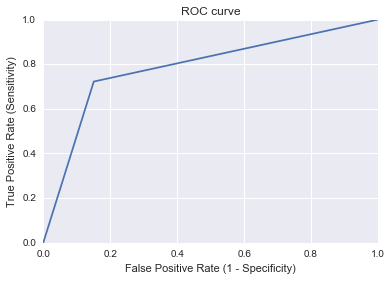

In [27]:
# plot ROC curve using y_test and predictions
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title("ROC curve")

#### 16. What does the ROC curve tell us?

As the line goes up, we correctly classify things, as it veers right we start misclassifying the more we predict

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [28]:
k_range = range(1,50)
params = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear'],
}

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [29]:
grid = GridSearchCV(lr, params, cv=5)
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.802024746907
{'penalty': 'l2', 'C': 0.047148663634573942, 'solver': 'liblinear'}
LogisticRegression(C=0.047148663634573942, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L2 Ridge penalty shrinks the coefficients by the same proportions but doesn't ever shrink them to 0. 
L1 Lasso penalty can shrink coefficients to 0, thus enacting variable selection. (from quora)

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

Ridge would be used to penalize a large weight more than many smaller ones, Lasso doesn't do this. Ridge would likley end up with many small weights and Lasso would end up with larger weights, but more zeros. (from quora)

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [31]:
knn = KNeighborsClassifier()
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [32]:
k_range = range(1,50)
params = dict(n_neighbors = k_range)
print params

grid = GridSearchCV(knn, params, cv = 10, scoring = 'accuracy')
grid.fit(X,y)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

[0.73115860517435316, 0.76940382452193479, 0.79190101237345334, 0.76602924634420699, 0.77502812148481437, 0.76940382452193479, 0.77502812148481437, 0.77165354330708658, 0.78065241844769406, 0.7604049493813273, 0.75703037120359951, 0.75703037120359951, 0.76715410573678289, 0.75028121484814403, 0.74465691788526434, 0.74240719910011244, 0.74465691788526434, 0.73565804274465696, 0.73003374578177727, 0.72328458942632168, 0.72778402699662548, 0.72440944881889768, 0.72778402699662548, 0.72215973003374578, 0.72103487064116989, 0.72103487064116989, 0.72103487064116989, 0.70978627671541061, 0.7142857142857143, 0.70528683914510681, 0.70753655793025871, 0.69741282339707533, 0.69741282339707533, 0.69066366704161974, 0.69741282339707533, 0.69178852643419575, 0.69291338582677164, 0.68503937007874016, 0.69066366704161974, 0.67604049493813279, 0.67604049493813279, 0.67266591676040499, 0.67604049493813279, 0.67491563554555678, 0.67041619797525309, 0.6692913385826772, 0.67379077615298089, 0.6670416197975

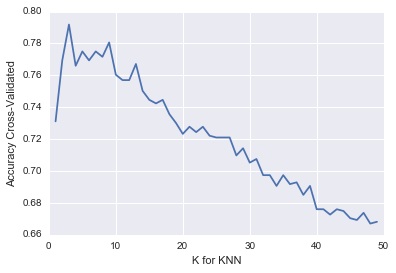

In [33]:
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores


# Plotting makes that even clearer

plt.plot(k_range, grid_mean_scores)
plt.xlabel("K for KNN")
plt.ylabel("Accuracy Cross-Validated")

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [34]:
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.791901012373
{'n_neighbors': 3}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)
model = knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

print "Accuracy score: ", accuracy_score(predictions, y_test)

Accuracy score:  0.780898876404


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

As n neighbors increases the bias also increases and the variance decreases.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

You should consider a few things when picking a model: is the problem linearly separable? Are the features independent? Is overfitting expected to be a problem? Are there speed/calculation/computation limitations? I would pick logistic regression (LR) if the problem was linearly separable. LR is also good at avoiding noise and avoiding overfitting.

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,y)
cvscore = cross_val_score(knn, X, y, cv=5)
cvscore.mean()

0.77504602297974989

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [37]:
cfmknn = confusion_matrix(y_test, predictions)
print cfmknn
print cfm, "There are more true positives in the Logistic Regression model than kNN."

[[100  13]
 [ 26  39]]
[[90 16]
 [20 52]] There are more true positives in the Logistic Regression model than kNN.


#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

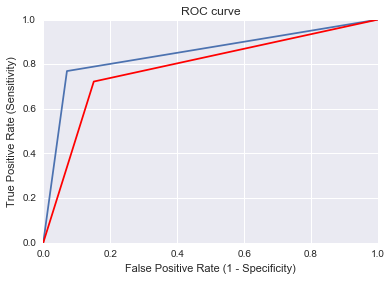

In [38]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, knn.predict(X_test))
plt.plot(fpr1, tpr1)
plt.plot(fpr,tpr, color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title("ROC curve")

#red denotes log regression, blue is knn